# Spam Ham Classifier

---
## Import Relevant Libraries
---

In [7]:
import os.path
import time
import glob
import json
import copy

from fileMaster import *

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
from matplotlib.colors import ListedColormap, to_rgb

import tensorflow as tf

import tqdm

-----
## Preliminary Cleaning | Clean ill-formated Data
-----

The raw data is of type 'str' and is of the form 'msg_type msg'. Each row of data is delimited by the newline character, which we can take care of my parsing the text file in python to a list of lines (each line being 1 row of data).

Upon visually inspecting the data, we realized that it has certain peculiarities, such as weird characters like "&lt;3". This could be possible due to the data provenance - it combines multiple SMS message data sources.

Hence, we will first be conducting data cleaning, by replacing the weird characters with their inferred meaning, and removing those we deem to be insignificant to our exploration.

In [8]:
with open(raw_data_txt, 'r', encoding='utf-8') as f:
    raw_lines = f.readlines()

df = pd.DataFrame(columns=['Type', 'Msg'])

count = 0

for line in raw_lines:
    # Encode Sensitive Info
    line = line.replace("&lt;#&gt;", "[NUM]").replace(" [NUM] ", "[NUM]")
    line = line.replace("&lt;DECIMAL&gt;", "[DEC]").replace(" [DEC] ", "[DEC]")
    line = line.replace("&lt;URL&gt;", "[URL]").replace(" [URL] ", "[URL]")
    line = line.replace("&lt;TIME&gt;", "[TIME]").replace(" [URL] ", "[URL]")
    line = line.replace("&lt;EMAIL&gt;", "[EMAIL]").replace(" [EMAIL] ", "[EMAIL]")

    # Replace Known Strings
    line = line.replace("&lt;3", "[HEART]").replace(" [HEART] ", "[HEART]")
    line = line.replace("&lt;", "<")
    line = line.replace("&gt;", ">")
    line = line.replace("&amp;", "&")

    # Replace Special Characters
    line = line.replace("\x92", "'")
    line = line.replace("Bill said u or ur rents", 'Bill said u or ur parents')
    line = line.replace("MORROW", "TOMORROW")
    line = line.replace(" ", "")
    line = line.replace("ü", "u")
    line = line.replace("Ü", "U")
    line = line.replace("", "")
    line = line.replace("", " ")

    # Replace Unknown Characters
    line = line.replace("鈥┾??〨ud", "[UNK]")

    _lst = line.split('\t')
    _type = _lst[0]
    _msg = _lst[1].strip()

    d = {'Type': _type, 'Msg': _msg}
    df2 = pd.DataFrame(d, [count])

    df = pd.concat([df, df2], axis=0)

    count += 1

df.to_csv(cleaned_data_csv, sep=',', encoding='utf-8', index=False)

In [15]:
df.head()

,Type,Msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


---
## Verify Tensorflow GPU is Identified
---

In [10]:
if tf.test.gpu_device_name():

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


---
# Exploratory Data Analysis
---

### Basic Statistics
Now, we will take a look at our data composition based on the 2 categories present - Ham and Spam.

In [11]:
df.groupby("Type").describe()

Msg                                                               
     count unique                                                top freq
Type                                                                     
ham   4827   4518                             Sorry, I'll call later   30
spam   747    642  Please call our customer service representativ...    4

Now, we can see that there are **minimal** repeat messages for both ham and spam - 30 for the former and 4 for the later, which represents only 6% of ham messages and 5% of spam messages (respectively). This is conducive for our model training, since it gives a large spread of data for our model to train on.

In [13]:
eda_type_count_df = pd.DataFrame({'Count': [df['Type'].value_counts()['ham'], df['Type'].value_counts()['spam']], 'Type': ['Ham', 'Spam']}, ['Ham', 'Spam'])
eda_type_count_fig = px.bar(eda_type_count_df, x='Type', y='Count', orientation='v', color_discrete_sequence=["#A0e7A0", "#FF8986"], color='Type', title='Count of Message Types', text_auto='', template='plotly')
eda_type_count_fig.show()

In total, there are **5,574** messages, of which around almost **87%** of the data comprises of ham messages, which points to a serious **class imbalance** in our data. This is, however, to be expected, due to the nature of our dataset - it is an organic source of messages, and hence, naturally, there will be more ham messages present than spam, despite the recent increase in spam messages many face recently. We shall subsequently explore ways to mitigate the impact of class imbalance when scoring our models later, since such an imbalance may lead to implicit biases.

### Feature Engineering

Firstly, we will be splitting the messages into individual words. This will allow us to get the word count, our first feature. We have decided to create our own tokenization function as we realized that the messages in our data set had many peculiarities. A naïve method of tokenization, by splitting based on spaces,  will not work, since we have weird symbol-like characters such as the following:

| Characters / Symbols | Meaning                                                              |
|----------------------|----------------------------------------------------------------------|
| &lt;                 | <                                                                    |
| &gt;                 | >                                                                    |
| &lt;#gt;             | numbers                                                              |
| &lt;DECIMAL&gt;      | decimal                                                              |
| &lt;URL&gt;          | url                                                                  |
| &lt;TIME&gt;         | time                                                                 |
| &lt;EMAIL&gt;        | email                                                                |
| Â ’                  | '                                                                    |
| Ü/ü                  | U/u                                                                  |
| &amp                 | &                                                                    |
| STS, CCH, SPA        | Unknown (to be removed)                                              |
| !鈥┾??〨               | unknown (Probably an Emoji, should be irrelevant so we will leave it as unknown) |

In [16]:
def tokenization(msg, punc_remove=False):
    punct_lst = ['...', '..', ",", '.', ';', '<', '>', '/', '"', '&', '!', '@', '#', '?', ]

    strng = msg

    for p in punct_lst:

        if ('..'  in strng or '...' in strng) and p == '.':
            pass
        else:
            temp_lst = strng.split(p)
            temp_lst = [x.rstrip() for x in temp_lst]
            temp_lst = [x.lstrip() for x in temp_lst]

            if punc_remove:
                strng = f' '.join(temp_lst)
            else:
                strng = f' {p} '.join(temp_lst)

    word_lst = strng.split(' ')

    if not punc_remove:
        count = 0

        punct_lst.remove('..')
        punct_lst.remove('...')

        for w in word_lst:
            try:
                for p in punct_lst:
                    if  w == 2*p and word_lst[count+1] == p:
                        word_lst[count] = 3*p
                        word_lst.pop(count + 1)
            except IndexError:  
                '''
                Index error occurs when we are at the last element of list and 
                try to access the next element, this means that the ".." is at the 
                last element so we do not to do anything abt it
                '''
                pass

            count += 1

    return word_lst

Above is our own rules-based function to tokenize the words in the messages.
Next, we will engineer our second feature - number of sentences.

In [17]:
def split_sentence(msg):
    punct_lst = ['...', '..', '.', '?', '!', ';']

    strng = msg

    for p in punct_lst:

        if ('..'  in strng or '...' in strng) and p == '.':
            pass
        else:
            temp_lst = strng.split(p)
            temp_lst = [x.rstrip() for x in temp_lst]
            temp_lst = [x.lstrip() for x in temp_lst]
            strng = f'|'.join(temp_lst)

    sentence_lst = strng.split('|')

    sym_lst = ['...', '..', ",", '.', ';', '<', '>', '/', '"', '&', '!', '@', '#', '?', ' ', '']
    for s in sentence_lst:
        if s in sym_lst:
            sentence_lst.remove(s)

    return sentence_lst

Above is our own rules-based function to tokenize the sentences in the messages.

Below, we will apply our tokenization functions for words and sentences to our dataframes, storing the word count and sentence count in "NumWords" and "NumSentences" respectively. We will store the tokenized words and sentences in "ListWords" and "ListSentence" respectively.

Lastly, we will engineer our third feature - character count.

In [18]:
# Tokenize Characters
df['CharCount'] = df['Msg'].apply(lambda x: len(x))

# Tokenize Words
df['ListWords'] = df['Msg'].apply(lambda x: tokenization(x))
df['NumWords'] = df['Msg'].apply(lambda x: len(tokenization(x, punc_remove=True)))

# Tokenize Sentences
df['ListSentence'] = df['Msg'].apply(lambda x: split_sentence(x))
df['NumSentences'] = df['Msg'].apply(lambda x: len(split_sentence(x)))

In [19]:
df.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1


First 5 messages and their character, words and sentences tokenized and counted.

In [11]:
df.tail()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences
5569,spam,This is the 2nd time we have tried 2 contact u...,160,"[This, is, the, 2nd, time, we, have, tried, 2,...",30,[This is the 2nd time we have tried 2 contact ...,5
5570,ham,Will u b going to esplanade fr home?,36,"[Will, u, b, going, to, esplanade, fr, home, ?, ]",9,[Will u b going to esplanade fr home],1
5571,ham,"Pity, * was in mood for that. So...any other s...",57,"[Pity, ,, *, was, in, mood, for, that., So, .....",12,"[Pity, * was in mood for that, So, any other s...",3
5572,ham,The guy did some bitching but I acted like i'd...,125,"[The, guy, did, some, bitching, but, I, acted,...",26,[The guy did some bitching but I acted like i'...,1
5573,ham,Rofl. Its true to its name,26,"[Rofl, ., Its, true, to, its, name]",6,"[Rofl, Its true to its name]",2


Last 5 messages and their character, words and sentences tokenized and counted.

### Histogram
Histograms of *CharCount*, *NumWords*, *NumSentence*

In [12]:
eda_charc_hist = px.histogram(df[['CharCount', 'Type']], 
                              x='CharCount', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Characters', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

It is interesting note that most **spam** messages have a **higher** character count (i.e. the mode of spam messages lies between 155-159 characters) than ham messages (i.e. mode of ham messages lies between 25-29 characters). Furthermore, the distribution of ham messages is **positively** skewed, whereas that of spam messages is **negatively** skewed.

In [13]:
eda_charc_hist = px.histogram(df[['NumWords', 'Type']], 
                              x='NumWords', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Words', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

It is interesting note that most **spam** messages have a **higher** word count (i.e. the mode of spam messages lies at 28 words) than ham messages (i.e. mode of ham messages lies at 6 words). Furthermore, the two distributions of CharCount and NumWords look fairly similar in shape. Hence, the distribution of ham messages is still **positively** skewed, whereas that of spam messages is still **negatively** skewed.

In [14]:
eda_charc_hist = px.histogram(df[['NumSentences', 'Type']], 
                              x='NumSentences', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Sentences', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

**Visually**, it is interesting to note that the **distribution** of **spam** messages **seem to follow a Normal Distribution**, with the mode of **spam** messages being at 3, which is significantly higher than that of **ham** messages (whose mode lies at 1 sentence). It is also unsurprising that the distribution of **ham** messages have a **positive** skew, considering that most people will limit their text to around a sentence in this day and age. Hence, our group postulates that, **ceteris paribus**, the **likelihood** of a message being a **spam** message is high should there be 3-4 sentences.

### Box-Plots of *CharCount*, *NumWords*, *NumSentence*
Next, we will be creating box plots for each of the 3 features

In [15]:
def genBoxPlot(var):
    box_fig = go.Figure()
    box_fig.layout.title = f'Box-Plots of Spam and Ham for {var}'
    ham_df = df[df['Type']=='ham']
    temp_df = df

    temp_df['Ham'] = ham_df[var]
    spam_df = df[df['Type']=='spam']
    temp_df['Spam'] = spam_df[var]


    for col in temp_df[['Ham', 'Spam']]:
        box_fig.add_trace(
            go.Box(x=temp_df[col].values,
                   name=temp_df[col].name,
                   fillcolor=["#CEF3CE", "#FFEBEB"][['Ham', 'Spam'].index(col)],
                   line={'color': ["#6BDB6B", "#FF8986"][['Ham', 'Spam'].index(col)]}
                   )
        )
    box_fig.update_traces(orientation='h')
    box_fig.show()
    return temp_df

Above is our own function to generate the box-plots for the various features, with each chart having both the spam and ham box plot plotted together to show the distribution of data.

In [16]:
# Call function to generate Box-Plots for CharCount, NumWords and NumSentences

genBoxPlot('CharCount')
genBoxPlot('NumWords')
genBoxPlot('NumSentences')

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3,3.0,NaN
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2,2.0,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2,NaN,2.0
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2,2.0,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1,1.0,NaN
...,...,...,...,...,...,...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,160,"[This, is, the, 2nd, time, we, have, tried, 2,...",30,[This is the 2nd time we have tried 2 contact ...,5,NaN,5.0
5570,ham,Will u b going to esplanade fr home?,36,"[Will, u, b, going, to, esplanade, fr, home, ?, ]",9,[Will u b going to esplanade fr home],1,1.0,NaN
5571,ham,"Pity, * was in mood for that. So...any other s...",57,"[Pity, ,, *, was, in, mood, for, that., So, .....",12,"[Pity, * was in mood for that, So, any other s...",3,3.0,NaN
5572,ham,The guy did some bitching but I acted like i'd...,125,"[The, guy, did, some, bitching, but, I, acted,...",26,[The guy did some bitching but I acted like i'...,1,1.0,NaN


Comparing the box-plots of **ham** and **spam** messages for CharCount, NumWords and NumSentences, our group notices that for each category, the **ham** and **spam** box-plots are **evidently different**. Hence, it is clear that **there exists some form of relation between CharCount, NumWords or NumSentences and the type of message (spam or ham).** Furthermore, the disparity between the box-plots vary the greatest for **CharCount** and **NumWords**, indicating that **CharCount and NumWords might be the best predictors for the type of message.** Whereas the disparity between the box-plots vary the least for **NumSentences**, indicating that **NumSentences might be the least effective predictor for the type of message.**

### Scatter Plots of *CharCount*, *NumWords*, *NumSentence*

In [17]:
scatter_plot = px.scatter_matrix(df,
                                 dimensions=["CharCount", "NumWords", "NumSentences"],
                                 color = "Type",
                                 template = 'plotly',
                                 color_discrete_map = {'ham': '#6BDB6B', 'spam': '#FF8986'},
                                 title = "Pair Plot of all 3 Features",
                                 )
scatter_plot.update_traces(diagonal_visible=False)
scatter_plot.show()

Analyzing the Scatter Plots for each type of count, it is immediately noticeable that there exists **a very strong linear relationship between CharCount and NumWords.** This makes sense as logically, **having more characters would generally mean more words, and vice versa.** Furthermore, this explains the **similarity in the distributions of the CharCount and NumWords histograms.** Hence, it is expected that **the correlation coefficient of CharCount and NumWords would be more than 0.8.**

However, the linear relation between NumSentences and CharCount or NumWords **does not display as strong of a linear relation between CharCount and NumWords.** This is evident from the Scatter Plots as there is **less of a clear line.** However, a **low to moderate linear relation can still be deduced.** This make sense as **having more characters and words might contribute to more sentences, but a sentence is ultimately defined by the use of certain punctuation marks, such as '.', '!' and '?'.** Hence, **the correlation coefficients of NumSentences and CharCount or NumWords would be expected to be below 0.8 but above 0.3.**

### Correlation Matrix Between *CharCount*, *NumWords*, *NumSentence*
We shall next take a look at the relationships between each of the features, using a correlation matrix

In [18]:
def genCorrMatrix(type_msg):
    corr_df = df[df['Type']==type_msg]
    corr_df = corr_df[['CharCount', 'NumWords', 'NumSentences']]
    fig = px.imshow(corr_df.corr(),
                    text_auto=True,
                    color_continuous_scale = 'reds',
                    template = 'plotly_white',
                    title = f"Correlation Matrix for {type_msg} messages")
    fig.show()

In [19]:
genCorrMatrix('ham')
genCorrMatrix('spam')

With reference to the above **correlation matrices**:

**Ham Messages**

*r* (ham correlation coefficient of CharCount and NumWords) = 0.984484

*r* (ham correlation coefficient of NumSentences with CharCount) = 0.7148112

*r* (ham correlation coefficient of NumSentences with NumWords) = 0.7031104

**Spam Messages**

*r* (spam correlation coefficient of CharCount and NumWords) = 0.8891148

*r* (spam correlation coefficient of NumSentences with CharCount) = 0.3351989

*r* (spam correlation coefficient of NumSentences with NumWords) = 0.32212


Therefore, our earlier deductions from the **scatter plots** were accurate as a **high positive correlation produces 0.8 ≤ *r* < 1** and a **low to moderate positive correlation produces 0.3 ≤ *r* ≤ 0.8**.

Note: ***r* refers to the Pearson product-moment correlation coefficient.** It is a measure of the strength of the linear relationship between two variables. Pearson's *r* falls in the range -1 ≤ *r* ≤ 1. A perfect positive correlation produces *r* = 1 and a perfect negative correlation produces *r* = -1. No correlation between two variables produces *r* = 0.

---
# Train-Test Split
---

Now, we will be performing a random train-test split of data, allocating Train Set with 75% of data and Test Set with 25% of data. The randomized set is then saved for coherent analysis; the same train test split will be used for our Neural Network model to ensure that the comparison between the 2 models will be a fair one.

In [20]:
# Train-test Split
predictors = ['CharCount', 'NumWords', 'NumSentences']

df['id'] = df.index + 1

re_split = False

if (not os.path.isfile(x_train_csv)) or re_split:
    x = df[predictors+['id']]
    y = pd.DataFrame(df['Type'].astype('category'))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

    # Save CSV
    if not os.path.isdir(train_test_folder):
        os.makedirs(train_test_folder)
    x_train.to_csv(x_train_csv, index=False)
    y_train.to_csv(y_train_csv, index=False)
    x_test.to_csv(x_test_csv, index=False)
    y_test.to_csv(y_test_csv, index=False)
else:
    # Load CSV
    x_train = pd.read_csv(x_train_csv)
    y_train = pd.read_csv(y_train_csv)
    x_test = pd.read_csv(x_test_csv)
    y_test = pd.read_csv(y_test_csv)

In [21]:
print(f'x_train count: {len(x_train.index)}')
print(f'y_train count: {len(y_train.index)}')
print(f'x_test count: {len(x_test.index)}')
print(f'y_test count: {len(y_test.index)}')

x_train count: 4180
y_train count: 4180
x_test count: 1394
y_test count: 1394


In [22]:
x_train.head()

,CharCount,NumWords,NumSentences,id
0,11,2,1,2098
1,36,8,3,4679
2,77,16,3,3318
3,23,4,2,5206
4,37,9,1,469


In [23]:
y_train.head()

,Type
0,ham
1,ham
2,ham
3,ham
4,ham


---
# Binary Decision Tree
---
Predicts *ham* or *spam* based on *CharCount, NumWords and NumSentences*, since these 3 features are shown to have some correlation with each other by virtue of the box plots.

The first model we will be using is that of Binary Decision Tree, since its ability to classify data into 2 categories fits our use case (of classifying messages into ham or spam).

In [24]:
def genDecTree(depth, _x_train, _x_test, _y_train, _y_test):
    _x_train = _x_train[predictors]
    _x_test = _x_test[predictors]

    decTree = DecisionTreeClassifier(max_depth = depth)  # create the decision tree object
    decTree.fit(_x_train, _y_train)                    # train the decision tree model

    # Plot Tree
    if depth == 2:
        width = 25
        font_size = 25
    elif depth == 4:
        width = 80
        font_size = 30
    elif depth == 6:
        width = 240
        font_size = 40
    elif depth == 10:
        width = 240
    height = width / 2

    fontsize = depth*12.5

    colors = ['lightgreen', 'salmon']

    if depth < 6:
        plt.figure(figsize=(width,height))
        t = tree.plot_tree(decTree, filled=True, rounded=True, feature_names=_x_train.columns,
                           class_names=["Ham", "Spam"], fontsize=font_size)

        for a, impurity, value in zip(t, decTree.tree_.impurity, decTree.tree_.value):
            # let the max value decide the color; whiten the color depending on impurity (gini)
            r, g, b = to_rgb(colors[np.argmax(value)])
            _c = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
            a.get_bbox_patch().set_facecolor((_c + (1-_c)*r, _c + (1-_c)*g, _c + (1-_c)*b))
            a.get_bbox_patch().set_edgecolor('black')

        plt.savefig(f'depth_{depth}_decTree.png')

    # Predict Response corresponding to Predictors
    y_train_pred = decTree.predict(_x_train)
    y_test_pred = decTree.predict(_x_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", decTree.score(_x_train, _y_train))
    print("Classification Precision \t:", )
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", decTree.score(_x_test, _y_test))


    # Plot the Confusion Matrix for Train and Test
    train_fig = px.imshow(confusion_matrix(y_train, y_train_pred), text_auto=True, color_continuous_scale = 'reds',
                          template = 'plotly_white', title = f"Confusion Matrix for Train set, depth {depth}")
    test_fig = px.imshow(confusion_matrix(y_test, y_test_pred), text_auto=True, color_continuous_scale = 'reds',
                         template = 'plotly_white', title = f"Confusion Matrix for Test set, depth {depth}")
    
    # Calculate the various positive and negative rates
    
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives 
    fpTrain = cmTrain[0][1] # False Positives 
    tnTrain = cmTrain[0][0] # True Negatives 
    fnTrain = cmTrain[1][0] # False Negatives 
    
    cmTest = confusion_matrix(y_test, y_test_pred)
    tpTest = cmTest[1][1] # True Positives 
    fpTest = cmTest[0][1] # False Positives 
    tnTest = cmTest[0][0] # True Negatives
    fnTest = cmTest[1][0] # False Negatives 

    print()
    tpr_train = tpTrain/(tpTrain + fnTrain)
    print("TPR Train:\t", tpr_train)
    tnr_train = tnTrain/(tnTrain + fpTrain)
    print("TNR Train:\t", tnr_train)
    fpr_train = fpTrain/(fpTrain + tnTrain)
    print("FPR Train:\t", fpr_train)
    fnr_train = fnTrain/(fnTrain + tpTrain)
    print("FNR Train:\t", fnr_train)

    print()
    tpr_test = tpTest/(tpTest + fnTest)
    print("TPR Test:\t", tpr_test)
    tnr_test = tnTest/(tnTest + fpTest)
    print("TNR Test:\t", tnr_test)
    fpr_test = fpTest/(fpTest + tnTest)
    print("FPR Test:\t", fpr_test)
    fnr_test = fnTest/(fnTest + tpTest)
    print("FNR Test:\t", fnr_test)

    # Display Classification Tree and Confusion Matrix  
    train_fig.show()
    test_fig.show()

    return (tpr_train, tnr_train, fpr_train, fnr_train), (tpr_test, tnr_test, fpr_test, fnr_test)

Above is our own function to generate the binary classification tree and confusion matrix to predict the type of message using CharCount, NumWords and NumSentences as predictors.

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8978468899521531
Classification Precision 	:

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9031563845050216

TPR Train:	 0.6877256317689531
TNR Train:	 0.9299503585217871
FPR Train:	 0.07004964147821291
FNR Train:	 0.31227436823104693

TPR Test:	 0.689119170984456
TNR Test:	 0.9375520399666945
FPR Test:	 0.06244796003330558
FNR Test:	 0.31088082901554404


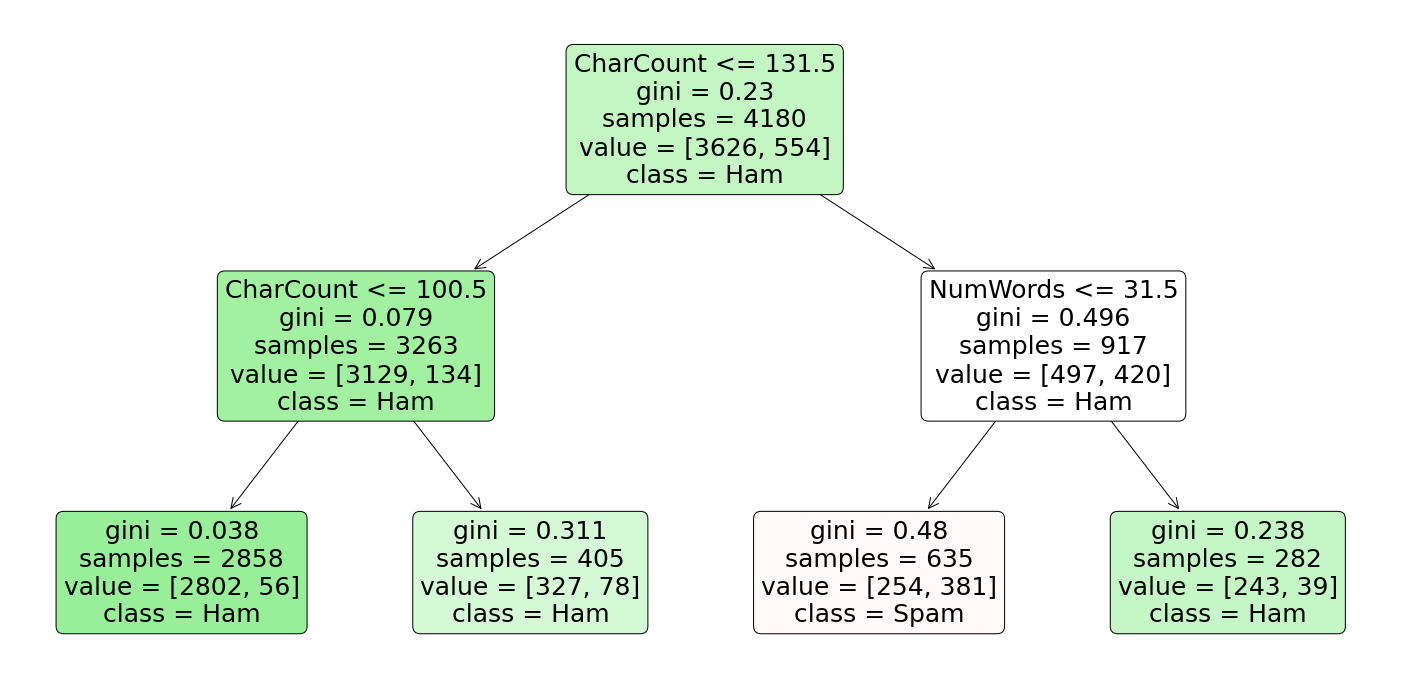

In [25]:
# Depth 2
metrics_2 = genDecTree(2, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9090909090909091
Classification Precision 	:

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.906025824964132

TPR Train:	 0.5469314079422383
TNR Train:	 0.9644236072807502
FPR Train:	 0.03557639271924986
FNR Train:	 0.45306859205776173

TPR Test:	 0.5284974093264249
TNR Test:	 0.9666944213155704
FPR Test:	 0.03330557868442964
FNR Test:	 0.47150259067357514


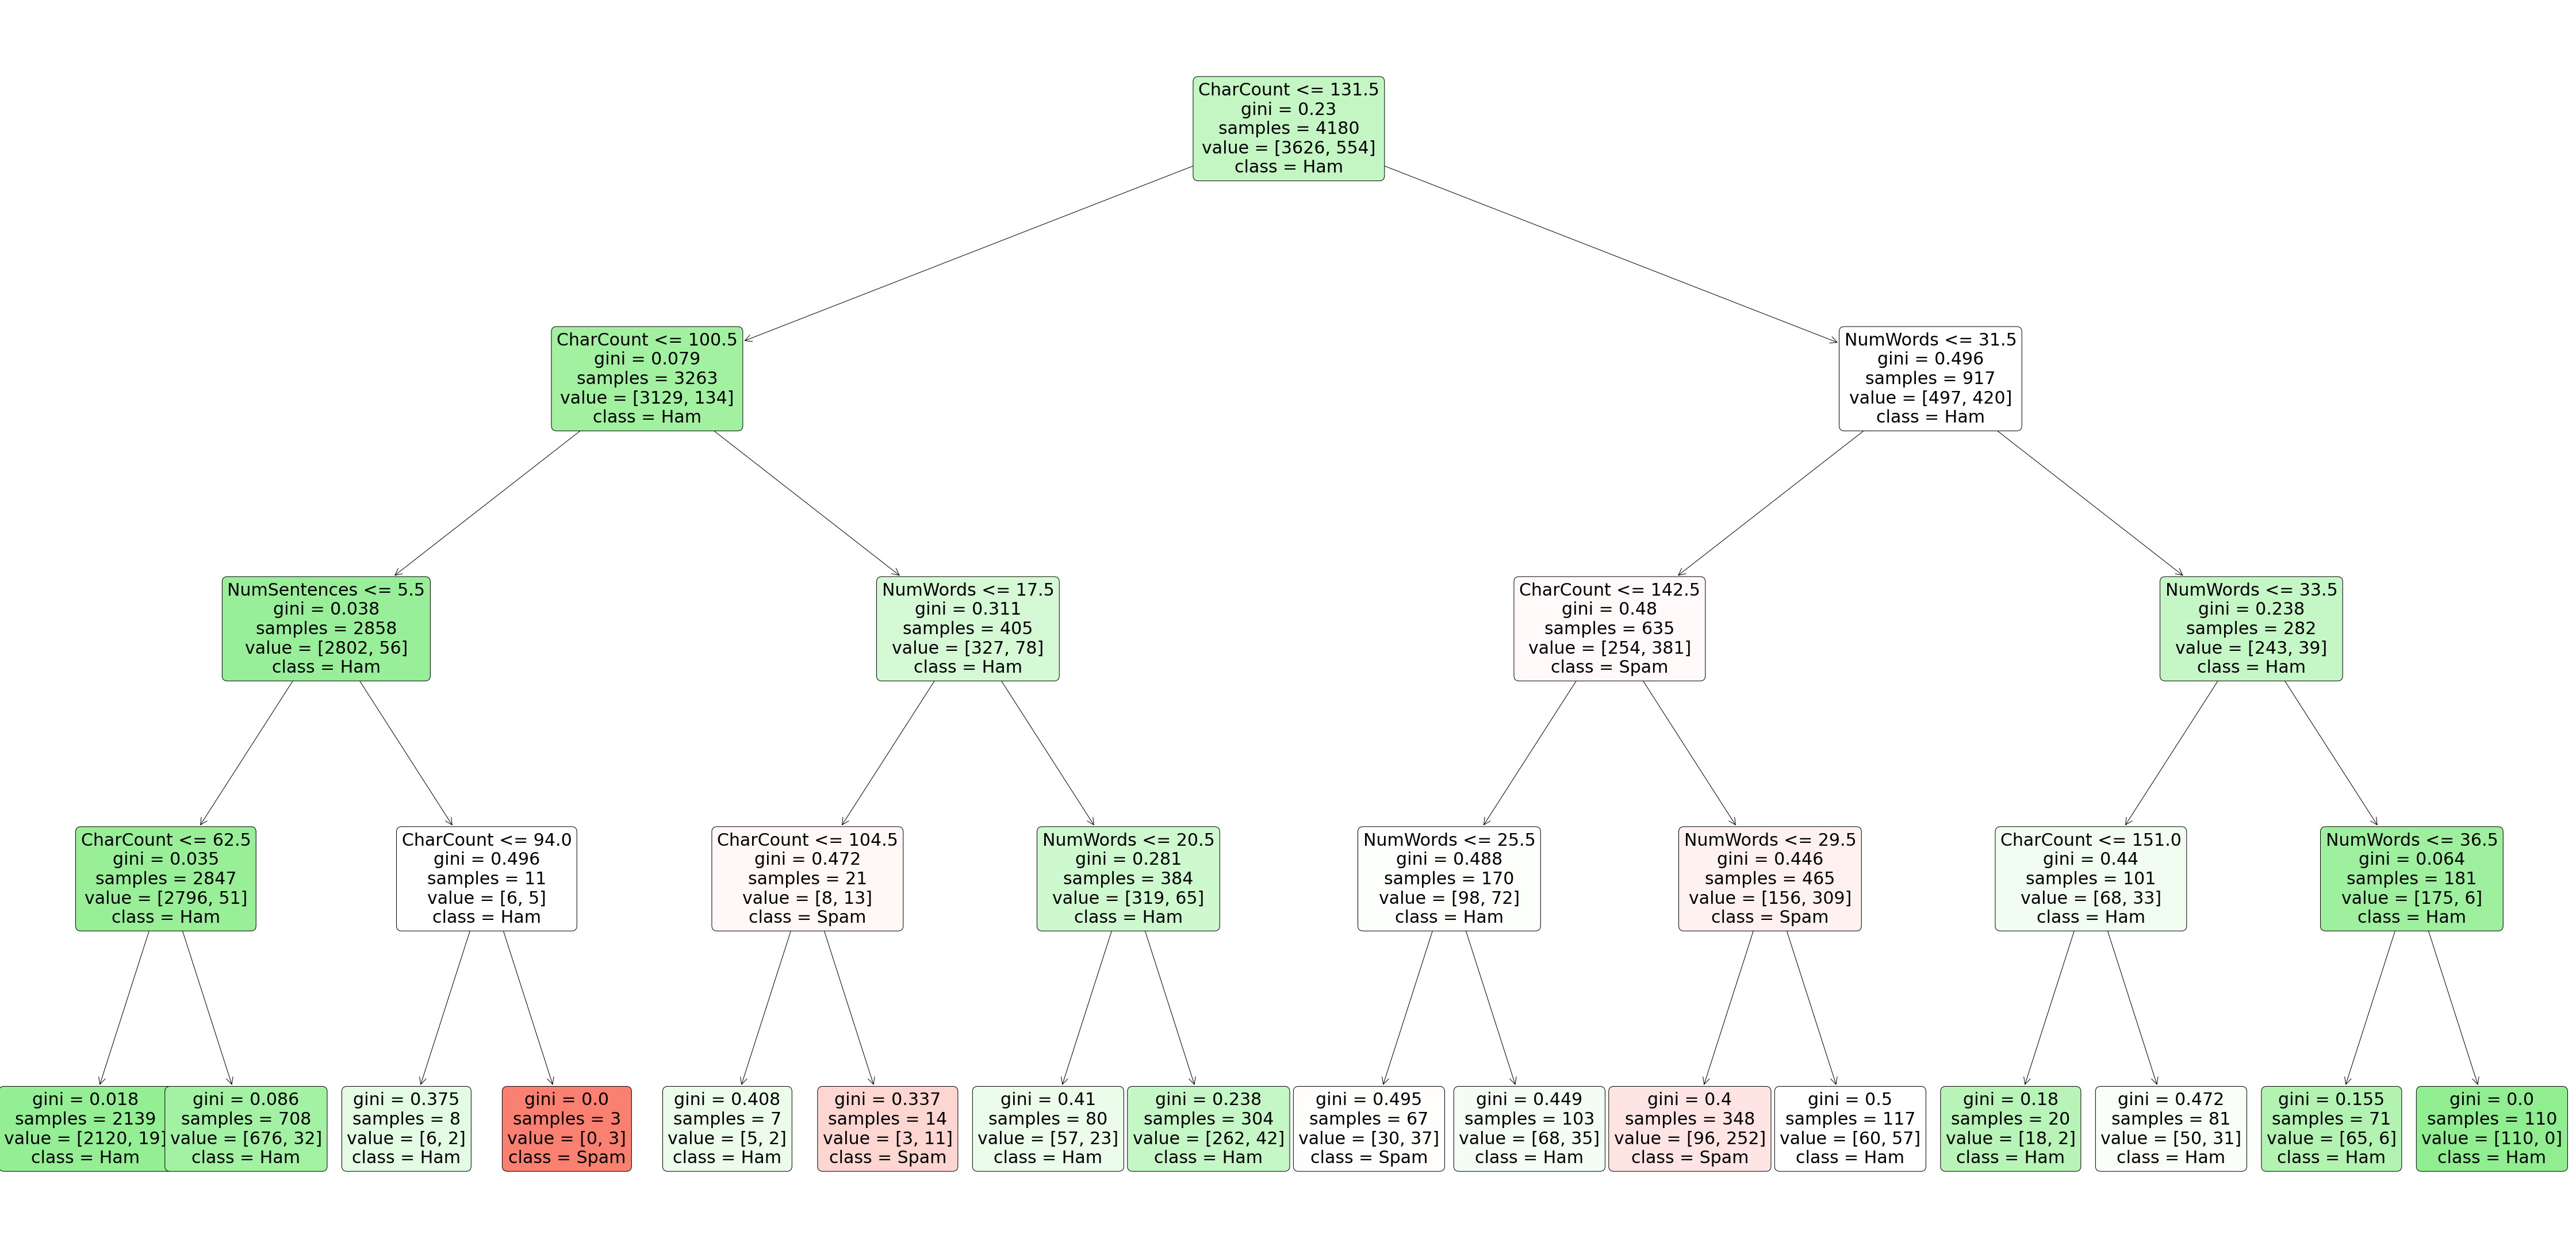

In [26]:
# Depth 4
metrics_4 = genDecTree(4, x_train, x_test, y_train, y_test)

In [27]:
# Depth 6
metrics_6 = genDecTree(6, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9169856459330143
Classification Precision 	:

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9010043041606887

TPR Train:	 0.6101083032490975
TNR Train:	 0.9638720353006067
FPR Train:	 0.03612796469939327
FNR Train:	 0.3898916967509025

TPR Test:	 0.5181347150259067
TNR Test:	 0.9625312239800167
FPR Test:	 0.03746877601998335
FNR Test:	 0.48186528497409326


In [28]:
# Depth 10
metrics_10 = genDecTree(10, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9483253588516747
Classification Precision 	:

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8981348637015782

TPR Train:	 0.740072202166065
TNR Train:	 0.9801434087148373
FPR Train:	 0.019856591285162713
FNR Train:	 0.259927797833935

TPR Test:	 0.6113989637305699
TNR Test:	 0.9442131557035803
FPR Test:	 0.05578684429641965
FNR Test:	 0.38860103626943004


### Understanding the Classification Tree and Confusion Matrix:


Generally, **increasing the number of levels** in a tree would give a **better fit on the training data**. However, this might result in **overfitting of the train data** at some point. In our case, this occurs at depth 6, as the Classification Accuracy of the train set becomes greater than that of the test set. This can be further seen with the depth 10 tree, where the Classification Accuracy of the train set becomes significantly greater than that of the test set. **Hence, we will not use depth 6 and beyond as a model for us to classify the messages.**

In our case, we take **Classification Accuracy, True Positive Rate (TPR) and False Positive Rate (FPR)** as our key metrics, as it is important to identify how accurate our model is in capturing the spam messages (TPR) and how inaccurate our model is in identifying ham messages as spam messages (FPR). Classification Accuracy provides us with the fraction of correct predictions.
    
It seems that **the depth 4 tree generally performs better than the depth 2 tree.** The Classification Accuracy of both train and test data for the depth 4 tree is higher than that of the depth 2 tree. Furthermore, the FPR for both train and test data of the depth 4 tree is lower than that of the the depth 2 tree, indicating that **the depth 4 tree classifies ham messages as spam messages less than the depth 2 tree.** This is important as **wrongly identifying a ham message as a spam message could be devastating in the real world context** - imagine a program that automatically deletes messages that are identified as spam: a person would not be able to receive ham messages that are wrongly detected as spam!
    
It is of note however, that the **depth 2 tree does perform better than the depth 4 tree in terms of TPR for both train and test data, indicating that the depth 2 tree identifies spam messages better than the depth 4 tree.** However, this could be due to the large imbalance in data set, where the ratio of ham:spam is roughly 13:2. Furthermore, as the number of levels increase, the depth of classification also increases, mitigating the effects of the imbalance. **Contextually, whilst identifying spam messages is important goal wise, identifying ham messages wrongly could bring about more severe consequences in reality.** Hence, our group deems that **depth 2's TPR being higher than that of depth 4's is not as significant as the results of the other key metrics.**
    
**Overall, our group agrees that the depth 4 tree is a better model on the current random split, as it performs better on both Classification Accuracy and FPR, the two more significant metrics.**

### Further Evaluation: Accuracy VS F1-score
**Accuracy:** Accuracy is a scoring system and it is calculated as: (True Positives + True Negatives) / (True Positives + True Negatives + False Positives + False Negatives).

Although accuracy is a scoring system that we have learnt, we do note that there exist a class imbalance in our dataset, as mentioned in our classification tree analysis where the ratio of ham:spam is roughly 13:2. Hence, we have decided to further research for other scoring systems that could possibly help alleviate the potential issues brought about by the class imbalance of the dataset. We came across the scoring system known as F-score.

**F1-score (F-measure, F1 measure):** An F-score is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric. It is calculated by: 2 x {(Precision x Recall) / (Precision + Recall)}.

Both accuracy and F1-score have a maximum value of 1 and a minimum value of 0. The key differences between accuracy and F1-score can be summarized in the following points below.

**Accuracy VS F1-score:**
* Accuracy is used when the True Positives and True negatives are more important, and the class distribution is similar.
* F1-score is used when the False Negatives and False Positives are more important, and is a better metric than accuracy when there are imbalanced classes.
* In the case of most real-life scenarios, such as that in our dataset, there exists an imbalanced class distribution. Hence, using the F1-score will be a better way to evaluate our model.

Thus, we will be using F1 score as a main metric of evaluation for both Binary Decision Tree and LSTM models.

In [29]:
# Depth 4 F1-score
def get_f1_score(metrics):
    (tpr_train, tnr_train, fpr_train, fnr_train), (tpr_test, tnr_test, fpr_test, fnr_test) = metrics
    precision_train = tpr_train / (tpr_train + fpr_train)
    recall_train = tpr_train/(tpr_train + fnr_train)
    f1_train = 2 * ((precision_train * recall_train) / (precision_train + recall_train))
    print("F1 Train:\t", f1_train)
    precision_test = tpr_test / (tpr_test + fpr_test)
    recall_test = tpr_test/(tpr_test + fnr_test)
    f1_test = ((precision_test * recall_test) / (precision_test + recall_test))
    print("F1 Test:\t", f1_test)

In [30]:
get_f1_score(metrics_4)

F1 Train:	 0.6912211209494462
F1 Test:	 0.33838929326132894


To reiterate, we have decided to firstly use a classification tree of depth 4 as further depths show signs of overfitting.

Now using F1 for evaluation of our Depth 4 Binary Decision Tree, it is clear that the classification accuracy of 90% painted a false picture of the quality of our model, possibly skewed by the class imbalance. **Our low F1 scores of 70% and 33% (for train and test respectively) indicates that that the classification tree model might not be very effective after all**. This leads us to create another model in order to properly evaluate our classification tree model by comparing their F-scores. **The model we have decided to use for comparison is a Long short-term memory (LSTM) model, a variant of the Recurrent Neural Network (RNN) architecture.**

---
# Natural Language Processing with Long Short-Term Memory (LSTM)
---

## Background Information

### What is RNN

First, let us understand what a Recurrent Neural Network is. Recurrent Neural Networks (RNN) are artificial neural networks which are used to model sequential data or time series data. In our case of ham or spam messages where sentiment analysis is concerned, this is the perfect model to use.

![RNN](images/rnn.png)

Sequence learning problems such as sentiment analysis of texts do not have a fixed size input, as the inputs at any timestamp is dependent on the current and previous input, and there is input at each timestamp.

RNNs have an Input Layer where they first receive the input and is processed through some computations in the Hidden Layer which finally results in some output in the Output Layer. The key point of RNNs that enable it to handle sequence learning problems so well is that the output of a given step is provided alongside the input of the next step. This allows the RNN to remember previous steps in the sequence.

### Long Term Dependency Problem of RNN
However, RNNs suffer from long term dependency problems. This means that as the number of inputs and information increases over time, the amount of information needed to process increases and the RNN becomes less effective at learning the input provided.

RNN utilizes the gradient descent algorithm to find the optimal global minimum of the cost function setup for the network. However, as the number of hidden layers increases, the value of gradient further reduces. This problem is known as the vanishing gradient problem. Due to this problem, the gradients slowly vanish until they simply die off. Once they do, the gradient flow stops and the neural network stops learning.

A solution to this is to use an LSTM cell instead of an RNN cell.

### Long Short-Term Memory Cell (LSTM)

![LSTM](images/lstm.png)

There are three parts in the LSTM cell: the Forget Gate, Input Gate and Output Gate:
* **Forget Gate**: The Forget Gate decides which information stored in the current state is no longer contextually relevant and can be forgotten.
* **Input Gate**: The Input Gate decides what new information should be added and stored in the current state.
* **Output Gate**: The Ouput Gate decides which information stored in the current state should be output in that particular instance.

The gates can be assigned a value of 0 to 1, 0 meaning no information gets passed through and 1 meaning all information gets passed through. LSTMs are a special kind of recurrent neural network capable of learning long-term dependencies.

#### Diagrammatic Comparison:
![LSTM_vs_RNN](images/lstm_vs_rnn.png)

## LSTM Model Pre-Processing: Feature Processing

### Get Word Index
As for the level of granularity of our tokenization, we have decided to tokenize at the word level and leave out characters. This is because there is a high correlation between number of words and characters, as can be seen in this correlation matrix earlier on. Thus, we hypothesize that using either words or chars as features will give us around the same performance.

We have decided to use the tokenization function that we had created earlier on to generate the word index required for the one-hot encoding function, instead of using cookie-cutter functions like that of tokenizer.fit() from tensorflow keras. This is for both consistency and relevancy: our custom tokenization function is made specific to the dataset, and handles the intricacies of the dataset better than a cookie-cutter tokenization functions.

Hence, we decided to supply the word index generated from our tokenized messages required by the tensorflow tokenizer class rather than simply calling the tokenizer.fit function.

In [24]:
def get_word_idx(_df, col_name):
    def _fn():
        _word_idx = {}
        _count = 1
        for idx, row in _df[col_name].iteritems():
            # print(f"row: {row}")
            for word in row:
                if word not in _word_idx.keys():
                    _word_idx[word] = _count
                    _count += 1

        return _word_idx

    if not os.path.isfile(word_idx_json): # json cached word idx file does not exist, thus get file
        word_idx = _fn()

        # write to json file
        with open(word_idx_json, 'w') as outfile:
            json.dump(word_idx, outfile, indent=4)

    else: # json file found, read json file into word_idx dict
        with open(word_idx_json, 'r') as openfile:
            word_idx = json.load(openfile)

    return word_idx

In [27]:
word_idx_dict = get_word_idx(df, 'ListWords')
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
tokenizer.word_index = word_idx_dict

### One-Hot Encode tokenized words
Next, the one-hot encoding function is applied to all rows of the dataframe, converting our list of words into a sequence of numbers. This is because our words must first be represented in numerical form before input into the embedding layer, since most machine learning algorithms are only able to work with numerical data and are unable to handle raw textual data in the learning stages.

In [26]:
df['TokenizedMsg'] = tokenizer.texts_to_sequences(df['Msg'].to_list())
df.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,id,TokenizedMsg
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3,1,"[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, ..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2,2,"[24, 25, 26, 27, 28, 29]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2,3,"[30, 31, 10, 32, 33, 34, 35, 36, 37, 38, 39, 4..."
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2,4,"[56, 57, 58, 59, 60, 61, 56, 62, 63, 64, 58]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1,5,"[65, 66, 67, 68, 69, 70, 36, 71, 69, 72, 73, 7..."


We now call our function to index the words on the **same list of words from our Classification Tree (ListWords)**. This is to reduce the number of base differences between the two models to **ensure a fairer comparison between the two models**. Afterwards, we use Tensorflow to tokenize the words and pass in our own generated word indexes. Above shows the first 5 messages with their tokenized message form.

### Pad Sequences
All neural networks require to have **inputs with same shape and size**. However, it is near impossible that textual inputs will always have the same length. Hence, **data padding or truncation is necessary** for our model in order to ensure that the **messages we are working with are of the same length**.

In this case, we define the max length of words to be 39, since the BoxPlots for Spam and Ham of NumWords provide us with the data that the max number of words in a spam message is 39, and the upper fence for ham messages is 37, with several above 37 as outliers. Hence, **a majority of both spam and ham messages should fall within the 39 words range.**

Doing so prevents the issue of over padding and skewing our results as most messages should not require much padding.

In [29]:
# Pad Sequences

df['TokenizedMsg'].to_list()
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(df['TokenizedMsg'].to_list(), maxlen=39)

count = 0

df['PaddedMsgs'] = [[] for x in range(len(padded_seq))]

for idx, row in df.iterrows():
    for s in padded_seq[idx]:
        row['PaddedMsgs'].append(s)

df.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,id,TokenizedMsg,PaddedMsgs
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3,1,"[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2,2,"[24, 25, 26, 27, 28, 29]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2,3,"[30, 31, 10, 32, 33, 34, 35, 36, 37, 38, 39, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 30, 31, 10, 32, 33, 3..."
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2,4,"[56, 57, 58, 59, 60, 61, 56, 62, 63, 64, 58]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1,5,"[65, 66, 67, 68, 69, 70, 36, 71, 69, 72, 73, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Above shows the results of the first five TokenizedMsg after padding. In the PaddedMsgs column, it can be seen that the after padding, the new list of tokenized words is different, with the necessary 0s padded in at the front. Sentences with more than 39 words will be truncated to 39.

## Update Train & Tests with current cols
For consistency, the same train test split for Binary Decision Tree must be used for LSTM, in order to provide for a fair comparison of results. To achieve that, we will be joining our newly one-hot encode and padded data to our previous x_train, x_test, y_train and y_test data.

#### Check train-test split shape pre-merge:

In [41]:
print(f'x_train count: {len(x_train.index)}')
print(f'y_train count: {len(y_train.index)}')
print(f'x_test count: {len(x_test.index)}')
print(f'y_test count: {len(y_test.index)}')

x_train count: 4180
y_train count: 4180
x_test count: 1394
y_test count: 1394


#### Merge train & test dataframe with updated dataframe:

In [42]:
x_train = pd.merge(df, x_train, on=['CharCount', 'NumWords', 'NumSentences', 'id'], how='right')
x_test = pd.merge(df, x_test, on=['CharCount', 'NumWords', 'NumSentences', 'id'], how='right')

#### Verify shape did not change post-merge:

In [43]:
print(f'x_train count: {len(x_train.index)}')
print(f'y_train count: {len(y_train.index)}')
print(f'x_test count: {len(x_test.index)}')
print(f'y_test count: {len(y_test.index)}')

x_train count: 4180
y_train count: 4180
x_test count: 1394
y_test count: 1394


#### Columns of train and test dataframes have been updated.

In [44]:
x_train.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam,id,TokenizedMsg,PaddedMsgs
0,ham,I'm done...,11,"[I'm, done, ...]",2,[I'm done],1,1.0,NaN,2098,[183],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,Wewa is 130. Iriver 255. All 128 mb.,36,"[Wewa, is, 130, ., Iriver, 255, ., All, 128, m...",8,"[Wewa is 130, Iriver 255, All 128 mb]",3,3.0,NaN,4679,"[10971, 111, 10973, 1794, 10975]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ham,I know girls always safe and selfish know i go...,77,"[I, know, girls, always, safe, and, selfish, k...",16,[I know girls always safe and selfish know i g...,3,3.0,NaN,3318,"[66, 396, 4718, 374, 1253, 84, 8992, 396, 188,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ham,Me fine..absolutly fine,23,"[Me, fine, .., absolutly, fine]",4,"[Me fine, absolutly fine]",2,2.0,NaN,5206,"[2750, 976]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,When are you going to ride your bike?,37,"[When, are, you, going, to, ride, your, bike, ...",9,[When are you going to ride your bike],1,1.0,NaN,469,"[867, 563, 93, 330, 36, 581, 122]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [45]:
x_test.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam,id,TokenizedMsg,PaddedMsgs
0,ham,If you r @ home then come down within 5 min,43,"[If, you, r, @, home, then, come, down, within...",10,[If you r @ home then come down within 5 min],1,1.0,NaN,2370,"[460, 93, 1818, 625, 186, 64, 673, 347, 2804, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,I am on the way to ur home,26,"[I, am, on, the, way, to, ur, home]",8,[I am on the way to ur home],1,1.0,NaN,3993,"[66, 534, 181, 171, 302, 36, 316, 186]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ham,Also fuck you and your family for going to rho...,132,"[Also, fuck, you, and, your, family, for, goin...",28,[Also fuck you and your family for going to rh...,1,1.0,NaN,5488,"[3734, 3753, 93, 84, 122, 3138, 95, 330, 36, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3734, 375..."
3,ham,So there's a ring that comes with the guys cos...,112,"[So, there's, a, ring, that, comes, with, the,...",21,[So there's a ring that comes with the guys co...,3,3.0,NaN,813,"[334, 397, 33, 2985, 327, 723, 114, 171, 1367,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,Having lunch:)you are not in online?why?,40,"[Having, lunch:)you, are, not, in, online, ?, ...",8,"[Having lunch:)you are not in online, why]",2,2.0,NaN,558,"[2932, 2933, 563, 112, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Create Word Vectorizer Function using Word Vectors from GloVe
Next, the sequence must be vectorized. This is essential for NLP, since a key feature of NLP is its ability in understanding context from textual data. Vectorizing the sequences allows the algorithm to learn context through a numerical representation of the word’s meaning. Such a numeric vector input represents a word in a lower-dimensional space, allowing words with similar meaning to have a similar representation. To save on training time, we have decided to use GloVe embedding vector index from Stanford University.

In [36]:
def get_word2embedding_map(): # loads word vectors from GloVe data file into a dictionary, with the coefficients in an np array for each word
    _embeddings_idx = {}
    with open(glove_300d, encoding="utf8") as _f:
        for _line in tqdm.tqdm(_f, "Reading GloVe"):
            word, coefs = _line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            _embeddings_idx[word] = coefs

    print(f"There are {len(_embeddings_idx)} word vectors.")
    return _embeddings_idx

In [37]:
def get_embedding_vectors(_tokenizer, _word2embedding_map, _embedding_size):
    word_index = _tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, _embedding_size)) # initializes all cells of matrix to 0
    for word, i in word_index.items():
        embedding_vector = _word2embedding_map.get(word) # gets embedding vector for word
        if embedding_vector is not None:
            # words not found will remain as 0s
            embedding_matrix[i] = embedding_vector # assigns matrix for words found
    return embedding_matrix

#### Set Up Embedding Index:

In [38]:
word2embedding_map = get_word2embedding_map()

Reading GloVe: 400000it [00:43, 9217.71it/s]

There are 400000 word vectors.


## Format Inputs for Model

#### Format features
Next, we have to ensure that our inputs are in the form accepted by the input layer of our model. We will need to ensure that our input shape is of rank 2, and we will do that by converting the x_train and x_test sets to numpy arrays.

In [52]:
_x_train = np.array(x_train['PaddedMsgs'].to_list())
_x_test = np.array(x_test['PaddedMsgs'].to_list())

#### One-Hot Encode Labels:
As we have done with the features, we most do the same for our labels. However this time, we need only to encode the categories of a dictionary of key size 2: containing keys 'ham' and 'spam', with 'ham' being 0 and 'spam' being 1.

In [53]:
label2int = {"ham": 0, "spam": 1}

_y_train = []
_y_test = []

for idx, row in y_train.iterrows():
    _y_train.append(label2int[row['Type']])

for idx, row in y_test.iterrows():
    _y_test.append(label2int[row['Type']])

_y_train = tf.keras.utils.to_categorical(_y_train)
_y_test = tf.keras.utils.to_categorical(_y_test)

## Generate Model

#### Create an LSTM model using Keras Functional API
This model inherits from tensorflow keras model class, and initializes by instantiating the various layers in the model. In our case, that would be the input layer, followed by the embedding layer, which feeds into the LSTM layer that outputs to a dropout layer before it finally outputs to a fully connected layer with sigmoid activation function.

The dropout layer freezes neurons based on the specified dropout rate to prevent overfitting of data. We have elected to use sigmoid as our activation function it outputs probabilities between 0 and 1, perfect for a binary classification use case like our spam-ham classification, with ham being 0 and spam being 1

In [30]:
class LSTMModel(tf.keras.Model):
    def __init__(self, sequence_length, lstm_units, _tokenizer, _word2embedding_map, _embedding_size, _embedding_matrix, _activation):
        super(LSTMModel, self).__init__()
        self.inputs = tf.keras.layers.InputLayer()
        self.embedding = tf.keras.layers.Embedding(
            input_dim=len(_tokenizer.word_index)+1,
            weights=[_embedding_matrix],
            trainable=False,
            input_length=sequence_length,
            output_dim=_embedding_size
        )
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, recurrent_dropout=0.2, kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.dropout = tf.keras.layers.Dropout(rate=0.3)
        self.dense = tf.keras.layers.Dense(units=2, activation=_activation)

    def call(self, inputs):
        _input = self.inputs(inputs)
        _embed = self.embedding(_input)
        _lstm = self.lstm(_embed)
        _dropout = self.dropout(_lstm)
        _output = self.dense(_dropout)  # output
        return _output

#### Create a function to calculate F1-score:

In [31]:
def f1(y_true, y_pred):
    def recall_m(_y_true, _y_pred):
        tp = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(_y_true * _y_pred, 0, 1)))
        positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(_y_true, 0, 1)))

        _recall = tp / (positives + tf.keras.backend.epsilon())
        return _recall


    def precision_m(_y_true, _y_pred):
        tp = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(_y_true * _y_pred, 0, 1)))
        pred_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(_y_pred, 0, 1)))

        _precision = tp / (pred_positives + tf.keras.backend.epsilon())
        return _precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

#### Create a function to compile and fit LSTM to the dataset:

**Some terms to note:**
* Embedding Size: Word embedding layer size.
* Optimizer: An optimizer modifies the attributes of the neural network, such as weights and learning rate. It helps reduce the overall loss and improve the accuracy.
* Loss Function: Loss functions measure the deviation of an estimated value from its true value.
* Epochs: Epochs refers to the number of passes of the entire training dataset the machine learning algorithm has completed.

In [60]:
def compile_and_fit_lstm(_tokenizer, _word2embedding_map, hyper_param_dict={}):

    # default values for hyperparams
    sequence_length=39
    _embedding_size=300
    lstm_units=128
    _optimizer='adam'
    _loss='binary_crossentropy'
    _accuracy='binary_accuracy'
    _epochs = 10
    _batch_size = 64
    _activation = 'sigmoid'

    # change hyperparams if supplied via hyper_param_dict
    if 'tokenizer' in hyper_param_dict:
        _tokenizer = hyper_param_dict['tokenizer']
    if 'sequence_length' in hyper_param_dict:
        sequence_length = hyper_param_dict['sequence_length']
    """if 'input_shape' in hyper_param_dict:
        input_shape = hyper_param_dict['input_shape']"""
    if 'embedding_size' in hyper_param_dict:
        _embedding_size = hyper_param_dict['embedding_size']
    if 'accuracy' in hyper_param_dict:
        _accuracy = hyper_param_dict['accuracy']
    _embedding_matrix = get_embedding_vectors(_tokenizer, _word2embedding_map, _embedding_size)

    # constructs the model, defaults to 128 LSTM units
    _lstm = LSTMModel(
        _tokenizer=_tokenizer,
        lstm_units=lstm_units,
        _word2embedding_map=_word2embedding_map,
        sequence_length=sequence_length,
        _embedding_size=_embedding_size,
        _embedding_matrix = _embedding_matrix,
        _activation=_activation
    )

    if 'optimizer' in hyper_param_dict:
        _optimizer = hyper_param_dict['optimizer']
    if 'loss' in hyper_param_dict:
        _loss = hyper_param_dict['loss']
    if 'epochs' in hyper_param_dict:
        _epochs = hyper_param_dict['epochs']
    if 'batch_size' in hyper_param_dict:
        _batch_size = hyper_param_dict['batch_size']

    _lstm.compile(
        optimizer=_optimizer,
        loss=_loss,
        metrics=[_accuracy, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1]  # maybe define custom f1 score (taking in both precision and recall)
    )

    # initialize our TensorBoard callback for better visualization
    tensorboard = tf.keras.callbacks.TensorBoard(f"logs/spam_classifier_{time.time()}")

    # Clear backend
    tf.keras.backend.clear_session()

    # train the model
    _lstm.fit(_x_train,
             _y_train,
             validation_data=(_x_test, _y_test),
             batch_size=_batch_size,
             epochs=_epochs,
             callbacks=[tensorboard],
             verbose=1)
    _lstm.save(results_notebook / f'lstm_model_{_optimizer}_opt_{_loss}_loss_{_epochs}_epochs_{_embedding_size}_embedSize_{_batch_size}_batchSize')

    return _lstm

#### Create a function to evaluate the Loss, Accuracy, Precision, Recall and F-score of our model:

**Loss**: A loss function is a way of evaluating how well our algorithm models the dataset. The lower the loss, the more accurate our model is and vice versa. 

**Accuracy:** Accuracy is a scoring system and it is calculated as: (True Positives + True Negatives) / (True Positives + True Negatives + False Positives + False Negatives).

**Precision:** Given a set of results out of a processed document, Precision is the percentage value indicating how many of those results are correct.

**Recall:** Given a set of results out of a processed document, Recall is the percentage value indicating how many of the correct results are found (correct being based on the expectations of a certain application).

**F-score (F-measure, F1 measure):** An F-score is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric. It is calculated by: 2 x {(Precision x Recall) / (Precision + Recall)}.

In [61]:
def eval_model(_model):
    # get the loss and metrics
    result = _model.evaluate(_x_test, _y_test)

    # extract metrics
    loss = result[0]
    accuracy = result[1]
    precision = result[2]
    recall = result[3]
    f1_score = result[4]

    print(f"results: {result}")

    # print metrics
    print(f"[+] Loss:   {loss*100:.2f}%")
    print(f"[+] Accuracy: {accuracy*100:.2f}%")
    print(f"[+] Precision:   {precision*100:.2f}%")
    print(f"[+] Recall:   {recall*100:.2f}%")
    print(f"[+] F1 Score:   {f1_score*100:.2f}%")

In [72]:
if not os.path.isdir(results_notebook):
        os.makedirs(results_notebook)

rebuild_model = False

dir_lst = glob.glob(str(results_notebook / 'lstm_model**/'))

hyper_params = {'epochs': 10, 'optimizer': 'adam'}

if not dir_lst or rebuild_model:
    lstm = compile_and_fit_lstm(tokenizer, word2embedding_map, hyper_param_dict=hyper_params)
else:
    dir_lst.sort(key=os.path.getmtime)
    to_load = dir_lst[-1]
    lstm = tf.keras.models.load_model(to_load, custom_objects={'f1': f1})
    print(f"Loaded {to_load}")

eval_model(lstm)

Loaded D:\GitHub\SC1015-NLP-Spam-Detection-Project\data\results\notebook\lstm_model_adam_opt_binary_crossentropy_loss_10_epochs_300_embedSize_64_batchSize
44/44 [==============================] - 2s 47ms/step - loss: 0.1000 - binary_accuracy: 0.9638 - precision: 0.9621 - recall: 0.9656 - f1: 0.9642
results: [0.1000281348824501, 0.9637733101844788, 0.9621158242225647, 0.9655666947364807, 0.9642045497894287]
[+] Loss:   10.00%
[+] Accuracy: 96.38%
[+] Precision:   96.21%
[+] Recall:   96.56%
[+] F1 Score:   96.42%


## Evaluation of Results:

### **Accuracy:**
The accuracy score of our LSTM model is greater than that of our depth 4 classification tree model
**(0.9638 > 0.9060)**.

### **F1-score:**
The F-score of our LSTM model is **significantly** greater than that of our depth 4 classification tree model
**(0.9642 > 0.3383)**.

It is no surprise that our LSTM model gave us much better results in both accuracy and F-score. 

One thing our depth 4 classification tree model failed to account for was the possible meanings of words. Our classification tree model only naively made use of the inidividual counts of characters, words and sentences in order to differentiate ham and spam messages. In reality, the word choices and meanings could actually differ greatly across ham and spam messages. This however, was not the case in our LSTM model, where we made use of the GloVe algorithm for obtaining word embeddings or vectors. 

Furthermore, our team even kept the tokenization methods across both models constant. Regardless, not only were the accuracies and F-score higher, the F-score obtained from our LSTM model was nearly triple the result from the classification tree model. 

Hence, our group postulates that one of the most important factors of dealing with textual data is the getting the algorithm to understand the context of words, which can be achieved through word vectorization.

### Attempt Predictions

#### Our team will now use our LSTM model and attempt some prediction tests, to see how it would fare with data outside of our dataset.

In [48]:
def get_predictions(_msg, _tokenizer, _model):
    if _msg != '':
        sequence = tokenizer.texts_to_sequences([_msg])

        seq_length = 39

        # pad the sequence
        sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=seq_length)

        sequence = np.array(sequence)

        # get the prediction
        prediction = _model.predict(sequence)

        # decode one-hot encoded vector
        int2label = {0: 'Ham', 1: 'Spam'}
        return int2label[np.argmax(prediction)]
    else:
        return 'EmptyMsg'

In [49]:
predict_text = [
                # Spam
                'Your account is temporarily frozen. Please log in to to secure your account ',
                'You won a prize of 1,000$, click here to claim!',
                'Beautiful weekend coming up. Wanna go out? Sophie gave me your number. Check out my profile here: bit.ly/profileGB12RD',
                'Dear customer, Bank of America is closing your bank account. Please confirm your PIN at notbankofamerica.com/XJY23VB to keep your account activated.',
                 "You've won a prize! Go to bit.ly/yourprize001 to claim your $500 Amazon gift card",

                #ham
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.',
                'Hello I am Jerome.'
]

for m in predict_text:
    r = get_predictions(_msg=m, _tokenizer=tokenizer, _model=lstm)
    print(f"{r}: '{m}'")

Ham: 'Your account is temporarily frozen. Please log in to to secure your account '
Spam: 'You won a prize of 1,000$, click here to claim!'
Ham: 'Beautiful weekend coming up. Wanna go out? Sophie gave me your number. Check out my profile here: bit.ly/profileGB12RD'
Ham: 'Dear customer, Bank of America is closing your bank account. Please confirm your PIN at notbankofamerica.com/XJY23VB to keep your account activated.'
Spam: 'You've won a prize! Go to bit.ly/yourprize001 to claim your $500 Amazon gift card'
Ham: 'The article was published on 18th August itself'
Ham: 'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.'
Ham: 'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
Ham: 'Hello I am Jerome.'


### <blockquote>Evaluation of Predictions:

**Percentages of messages predicted correctly:**
* Ham Messages: 100%
* Spam Messages: 42.86% 
* Overall: 63.63%

It would seem that despite having a high accuracy and F-score, our LSTM model still seems to struggle in the real world context. It is interesting to note that the our LSTM model struggles more at predicting spam messages. This could be due to the class imbalance.

Hence, our team have decided to fine-tune our LSTM model.

### Model Fine-tuning:

#### This function fine-tunes our model:

In [104]:
from LSTMModel import TrainValidate


lst_glove = [50, 100, 200, 300]
optimizer_lst = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
loss_lst = ['binary_crossentropy', 'categorical_crossentropy', 'poisson'] # sparse_categorical_crossentropy is not used

# Varying glove, keeping rest of hyper-params constant
for g in lst_glove:
    train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=g,
        lstm_units=128,
        train=True,
    )

    train_val.compile_run(accuracy='accuracy',
        optimizer='adam',
        loss='binary_crossentropy',
        batch_size=64,
        epochs=10
)

# Varying optimizer, keeping rest of hyper-params constant
for o in optimizer_lst:
    train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=300,
        lstm_units=128,
        train=True,
    )

    train_val.compile_run(accuracy='accuracy',
        optimizer=o,
        loss='binary_crossentropy',
        batch_size=64,
        epochs=10
)

# Varying loss, keeping rest of hyper-params constant
for l in loss_lst:
    train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=300,
        lstm_units=128,
        train=True,
    )

    train_val.compile_run(accuracy='accuracy',
        optimizer='adam',
        loss=l,
        batch_size=64,
        epochs=10
)

    if l == 'poisson':
        train_val.eval_models()
        train_val.load_histories()

Epoch 1/10
66/66 [==============================] - 144s 2s/step - loss: 0.5403 - accuracy: 0.8589 - precision: 0.8396 - recall: 0.8467 - f1: 0.8445 - val_loss: 0.4690 - val_accuracy: 0.8558 - val_precision: 0.8563 - val_recall: 0.8551 - val_f1: 0.8560
Epoch 2/10
 8/66 [==>...........................] - ETA: 1:46 - loss: 0.4576 - accuracy: 0.8613 - precision: 0.8611 - recall: 0.8594 - f1: 0.8602

KeyboardInterrupt: 

In [ ]:
train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=300,
        lstm_units=128
)

train_val.eval_models()
train_val.load_history()

The TrainValidate class  run directly in the Python script due to performance issues.

The above training loop is for examplification.

Each epoch in the jupyter notebook took 1.5min to train whereas in the Python script it took around 45s. The Python script can be found in our GitHub repository.

From our tests, we have deduced that the best embedding size, optimizer, loss function and epochs are: 
* Embedding Size: 300
* Optimizer: RMSprop
* Loss Function: Categorical CrossEntropy
* Epochs: 17

This produced the best F-score of 97.49%.

#### The diagrams below shows the results of testing for the best optimizer, as an example:

![testing_optimizer1](images/optimizer_results_1.png)

![testing_optimizer2](images/optimizer_results_2.png)

The full set of results can be in the Github repository, under data>results>class, where each training loop is documented in the folders named with its respective hyperparameters used.

---
# Final Evaluations and Future Recommendation
---

Even after fine-tuning our LSTM model, the F-score is still only 97.49%. How can we further obtain a better F-score?

### RNN and LSTM: Encoder-Decoder Sequence to Sequence Model

![seq2seq](images/seq2seq.jpeg)

Both RNN and LSTM uses an Encoder-Decoder Sequence to Sequence Model. This means that sequential steps are taken to encode each input, until the last input. Then, a similar sequential sequence is taken to decode the inputs. With larger sequences, the information might get lost in the network. This leads to the vanishing gradient problem as we have mentioned earlier. Although LSTMs are able to alleviate the vanishing gradient problem, as the sequence size increases even more, the effectiveness of LSTMs will be reduced as well.

### Transformers: Encoder-decoder Architecture based on Attention Layers

#### Transformers are able to tackle the issues of an Encoder-Decoder Sequence to Sequence Model.

**Encoder-decoder Architecture based on Attention Layers:** <br>Transformers do not require any sequential computation per layer and only one single step is needed. It also only takes one step from the output to the first input for the gradient steps. Hence, transfomers do not suffer from the vanishing gradient problem since it is related to the length of the sequences.

![transformer_encoder_decoder](images/transformer_encoder_decoder.png)

<br>**Multi-Headed Attention:** <br>Instead of recurrent layers, transformers uses multi-headed attention layers. The self-attention mechanism allows inputs to interact with one another and decide which input should be focuses on. Multi-head Attention is a set of parallel self-attention layers which are concatenated to produce a single output.

![multiheaded_attention](images/multiheaded_attention.png)

<br><br>**Positional Encoding:** <br>This encodes each inputs' position in the sequence and hence retains the positional information of the word sequence. This is unlike the recurrent layer in the RNN and LSTM, which fails to model positional information of the word sequences. Positional information is since the order of words is important when used in a sentence.

![positional_encoding](images/positional_encoding.png)

### In summary:

![Transformers](images/transformers.png)

* Transformer is an encoder-decoder architecture based on attention layers: It is good for named entity recognition which is useful for differentiating ham or spam messages because spam messages have less contextual info and more typing errors than ham messages.
* Transfomers are also able to parallelize sequential data. 
* Transformers resolve the issue of vanishing gradient.

Hence, transfomers will not only be able to perform better in terms of scoring, but it would also train the data much faster than RNN of LSTM. Using a transformer model should be able to produce not only better scores, but also provide better results when classifying data outside the dataset.
